In [2]:
!pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all the necessary libraries and mounting the drive to the notebook as previously done.

In [3]:
import torch
import numpy as np
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch import nn
from sklearn.metrics import recall_score
from torchsampler import ImbalancedDatasetSampler

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_images_path = 'drive/MyDrive/Object_detection/Training_images'
validation_images_path = 'drive/MyDrive/Object_detection/Validation_images'


Transforming the train images to incorporate positional, rotational invariance and normalizing the tensor to reduce the range of input values into the neural network to optimise backpropogation.

The transformed images are segmented into batches of specified batch size.

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomRotation(20), transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
validation_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_images = datasets.ImageFolder(train_images_path, transform = train_transform)
validation_images = datasets.ImageFolder(validation_images_path, transform = validation_transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_images,  batch_size = batch_size, sampler = ImbalancedDatasetSampler(train_images))
validation_loader = torch.utils.data.DataLoader(validation_images, batch_size = batch_size, sampler = ImbalancedDatasetSampler(validation_images))

Let;s have a look at a batch:

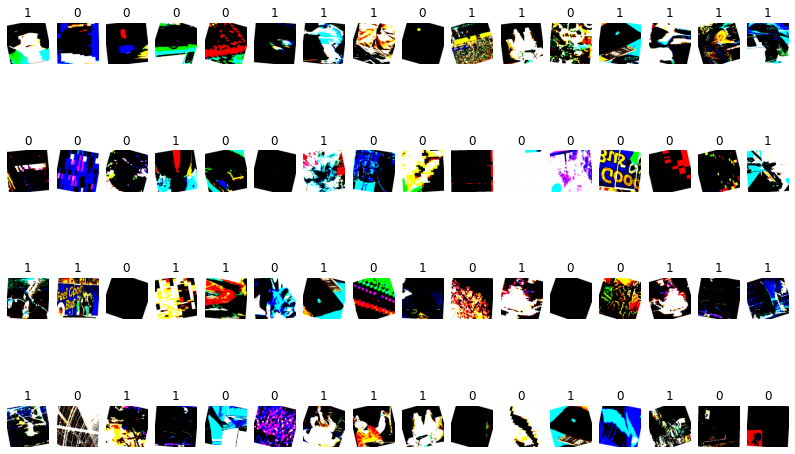

In [ ]:
batch = next(iter(train_loader))

rows = 4
columns = int(batch_size / rows)

plt.figure(figsize = (14, 9))

for pos in range(batch_size):
  plt.subplot(rows, columns, pos+1)
  plt.imshow(batch[0][pos].permute(1, 2, 0).numpy().astype('uint8'))
  plt.title(batch[1][pos].item())
  plt.axis('off')

plt.show()

After readying the train and validation datasets, it is now time to define the convolutional network. 

The CNN used for this project is resnet-18. The parameters of the pretrained model are freezed and the model is then moved to GPUs to exploit its robust capabilities. 

In [4]:
resnet_model = models.resnet18(pretrained = True)

for parameters in resnet_model.parameters():
  parameters.requires_grad = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

cuda


Resnet-18 was designed for 1000-class classification, but this project of object detection only has 2 classes: object and background. So, the final layer of the model is modified as per the requirements.

In [5]:
resnet_model.fc = nn.Sequential(
    nn.Linear(512, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256,2),
    
)

Next come the traning loop and validation loop.

The training loop and validation loops both accept images in batches. In the training loop, the model is trained and training loss is printed for every 32nd batch.

The model's performance is known when it looks at new images and predicts the class, in the validation loop.

In [ ]:
def train_loop(dataloader, model, optimizer, criterion):
  model.train()

  for batch, (images, labels) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch == 0:
      batch_size = len(images)

    if batch % 40 == 0:
      print(f'Training loss: {loss: 7f}           [{batch * batch_size} / {len(dataloader.dataset)}]')

In [ ]:
def validation_loop(dataloader, model, criterion):
  model.eval()
  validation_loss = 0
  batches = len(dataloader)
  accuracy = 0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)
    # accuracy+=1
    
    with torch.no_grad():
      logits = model(images)
      validation_loss += criterion(logits, labels)
      logits = logits.argmax(dim = 1)
      accuracy += (logits == labels).type(torch.float).sum().item()

  labels = labels.detach().cpu().numpy()
  logits = logits.detach().cpu().numpy()

  accuracy = accuracy / len(dataloader.dataset)
  sensitivity = recall_score(labels, logits)
  specificity = recall_score(labels, logits, pos_label = 0)
    
  print(f'Average validation Loss: {validation_loss / batches: 7f}      Accuracy: {accuracy*100: .2f}       Sensitivity: {sensitivity*100: .2f}      Specificity: {specificity*100: .2f}%')
  return validation_loss

Training loop and validation loop are both run sequentially over a certain number of epochs after setting the learning rate, an optimizer and a loss function appropriately.

Important thing to notice is the reducing validation loss, indicating that the model is performing better after every epoch.

The model is saved when the validation accuracy is at its highest.

In [ ]:
epochs = 30

model = resnet_model
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model.cuda()
criterion = criterion.to(device)

least_val_loss = np.inf

for epoch in range(epochs):
#   torch.cuda.empty_cache()
  print(f'-----------------epoch-{epoch+1}-----------------')
  train_loop(train_loader, model, optimizer, criterion)
  new_val_loss = validation_loop(validation_loader, model, criterion)

  if(new_val_loss < least_val_loss):
    least_val_loss = new_val_loss
    print('Saving the model..\n\n')
    model_save_name = 'resnet_model.pt'
    path = f'drive/MyDrive/Object_detection/{model_save_name}'
    torch.save(model, path) 

  print('\n')

-----------------epoch-1-----------------
Training loss:  0.704253           [0 / 18603]
Training loss:  0.308727           [2560 / 18603]
Training loss:  0.231677           [5120 / 18603]
Training loss:  0.266308           [7680 / 18603]
Training loss:  0.258675           [10240 / 18603]
Training loss:  0.478724           [12800 / 18603]
Training loss:  0.221073           [15360 / 18603]
Training loss:  0.217438           [17920 / 18603]
Average validation Loss:  0.469282      Accuracy:  82.94       Sensitivity:  55.56      Specificity:  96.55%
Saving the model..




-----------------epoch-2-----------------
Training loss:  0.131897           [0 / 18603]
Training loss:  0.131312           [2560 / 18603]
Training loss:  0.182547           [5120 / 18603]
Training loss:  0.255842           [7680 / 18603]
Training loss:  0.159426           [10240 / 18603]
Training loss:  0.180760           [12800 / 18603]
Training loss:  0.193691           [15360 / 18603]
Training loss:  0.171661         